In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## Optimization

Consider a problem of minimizing a certain function $f : \mathbb{R}^n \rightarrow \mathbb{R}$ (denoted **objective function**) given a certain set of **constraints**. Constraints are pre-conditions over the arguments of $f$, defining its domain.

The constraints define a set $S$ of **feasible solutions** that are acceptable answers to $f$. We would like to find an optimal solution $s^* \in S$ that minimizes $f$, i.e., $\forall s\in S: f(s^*) \leq f(s)$

This is a very general problem and a vast area of research. For some instances of $f,S$ there are mathematical and algorithmic approaches that can be used to find optimal solutions.

Herein we will present module `cvxpy` that solves **convex optimization** problems. This module is an interface to [CVX](http://cvxr.com/dcp/), an optimization software that unifies several types of optimization, like [linear programming](https://en.wikipedia.org/wiki/Linear_programming), [quadratic programming](https://en.wikipedia.org/wiki/Quadratic_programming) and others.

In [ ]:
from cvxpy import *

Consider the following optimization problem:

`minimize` $x^2 + y^2$

`subject to` 

+ $x \geq 0$

+ $2x+y=1$

CVX requires that we denote the optimization variables in a problem using function `Variable`. Then we state the objective function expression using `Minimize` and its constraints as a list of expressions.

Function `Problem` receive both and define the optimization problem.

In [ ]:
x = Variable(1)
y = Variable(1)

objective   = Minimize(x**2 + y**2)
constraints = [ x >= 0, 2*x + y == 1 ]
problem     = Problem(objective, constraints)

Now we just need to solve it and, if all goes well, check the values of $s^*$:

In [ ]:
problem.solve()
print('x = %3.2f, y = %3.2f' % (x.value, y.value))

x = 0.40, y = 0.20




---



### Linear Optimization

A linear program (LP) has an affine objective and constraint functions (affine functions are linear functions with translation).

The feasible set is a polyhedron. The famous [simplex method](https://en.wikipedia.org/wiki/Simplex_algorithm) is an algorithm that moves on the vertices of this polyhedron to find the optimal solution.

Example: choose cheapest healthy diet $x$ with quantities $x_1 \ldots x_n$ of $n$ foods, where (a) one unit of food $x_j$ costs $c_j$ and contains amount $A_{ij}$ of nutrient $i$; (b) healthy diet requires nutrient $i$ in quantity at least $b_i$.

That is:

`minimize` $c^T x$

`subject to` 

+ $Ax \geq b$

+ $x \geq 0$ 

Let's define an instance of this problem:

In [ ]:
# nutrient's amounts (row is nutrient, column is food)
A = np.array([[10, 40,  0, 20], 
              [ 5, 20, 15, 11], 
              [20, 10,  6,  0]])
# minimal amounts of each nutrient
b = np.array([50, 10, 20])
# costs of each food
c = np.array([30, 10, 5, 15])

The problem specification in CVX:

In [ ]:
x = Variable(4)      # 4x1 vector

objective   = Minimize( c.T @ x ) 
constraints = [A @ x >= b, x >= 0]
problem     = Problem(objective, constraints)

And its solution:

In [ ]:
problem.solve()

print("Food's amounts: ", np.round(x.value,3))
print("Cost of diet ", np.round(problem.value,3))

Food's amounts:  [-0.    1.25  1.25  0.  ]
Cost of diet  18.75




---



### Example: Chebyshev center

The [Chebyshev center](https://en.wikipedia.org/wiki/Chebyshev_center) $x_c$ is the center of the largest inscribed circle in a polyhedron (in a sense, the deepest point inside the polyhedron). 

Be $r$ the radius of that circle, the problem specification is,

`maximize` $r$

`subject to` 

+ $a_i^T x_c + r \Vert a_i \Vert_2  \leq b_i, i=1\ldots m$

where the polyhedron is defined by $m$ lines $a_i^T x = b_i$, and $a_i^Tx \leq b_i$ correspond to halfspaces (cf. explanation at Boyd's book, pgs 148,149).


Let's create an example with four lines:

In [ ]:
A = np.array([[2,  1], [2, -1], [-1,  4], [-1, -2]])
b = np.array([1,1,1,1])

normA = np.sum(A**2, 1)**0.5 # compute norm for each line

This data define the following polyhedra:

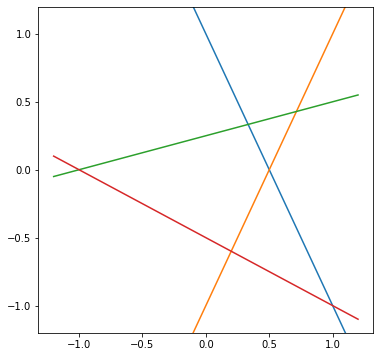

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_ylim([-1.2,1.2])

xs = np.linspace(-1.2,1.2,20)
for i in range(A.shape[0]):
  ys = (-A[i,0]/A[i,1])*xs + b[i]/A[i,1]
  ax.plot(xs, ys)

Specifying the problem in CVX:

In [ ]:
r   = Variable(1, name="radius")
x_c = Variable(2, name="center")

objective   = Maximize( r ) 
constraints = [A @ x_c + r * normA <= b]
problem     = Problem(objective, constraints)

In [ ]:
problem.solve()

r   = np.round(r.value,3)
ctr = np.round(x_c.value,3)

print("Circle's center: ", ctr)
print("Radius ", r)

Circle's center:  [ 0.038 -0.114]
Radius  [0.362]


Let's visualize the solution:

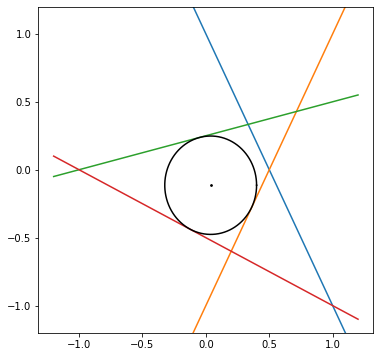

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_ylim([-1.2,1.2])

xs = np.linspace(-1.2,1.2,20)
for i in range(A.shape[0]):
  ys = (-A[i,0]/A[i,1])*xs + b[i]/A[i,1]
  ax.plot(xs, ys)

# draw center
ax.scatter(ctr[0], ctr[1], color='k', s=3)

# draw circle
theta = np.linspace(0,2*np.pi,100)  # 0 <= θ <= 2π
x1 = r * np.cos(theta) + ctr[0]
x2 = r * np.sin(theta) + ctr[1]
ax.plot(x1, x2, color='k');



---



## Quadratic Programming

A convex optimization problem is called a quadratic programming (QP) if the objective function is a convex quadratic and the constraint functions are affine. 

The first model was an example of this class of problems.

A classic problem is Least Squares (ie, linear regression).

The model for Least Squares is,

`minimize` $\|Y - X\beta\|_2^2$

In [ ]:
np.random.seed(101)

# Make some fake data
n = 100  
p = 6  # 6D problem

trueBetas = np.arange(-p//2,p//2).reshape(p,1)
X = np.array(np.random.randn(n*p)).reshape(n,p)
Y = X @ trueBetas + np.random.randn(n).reshape(n,1) # add some noise

Specify the model with CVX and run it with the data:

In [ ]:
betas     = Variable((p,1))
objective = Minimize(sum((Y - X @ betas)**2))
problem   = Problem(objective)

problem.solve()

# compare true and estimate beta parameters
print(np.hstack([trueBetas, np.round(betas.value,3)]))

[[-3.    -3.03 ]
 [-2.    -2.084]
 [-1.    -1.039]
 [ 0.    -0.054]
 [ 1.     0.92 ]
 [ 2.     2.036]]


Of course, linear regression is already implemented in many modules, we don't need CVX to solve it.

But assume we would like that all $\beta_i \geq 0$. There is no analytical solution for this problem, but for CVX is just business as usual:

In [ ]:
constraints = [betas >= 0]
problem   = Problem(objective, constraints)
problem.solve()

# compare true and estimate beta parameters
print(np.hstack([trueBetas, np.round(betas.value,3)]))

[[-3.    -0.   ]
 [-2.    -0.   ]
 [-1.    -0.   ]
 [ 0.    -0.   ]
 [ 1.     0.325]
 [ 2.     1.904]]


And if we would like to force $2\beta_2 + \beta_3 - \beta_6 = 0$?

In [ ]:
A = np.array([0, 2, 1, 0, 0, -1])
constraints = [A @ betas == 0]

problem   = Problem(objective, constraints)
problem.solve()

# compare true and estimate beta parameters
print(np.hstack([trueBetas, np.round(betas.value,3)]))

[[-3.    -2.868]
 [-2.     0.112]
 [-1.     0.205]
 [ 0.    -0.298]
 [ 1.     0.665]
 [ 2.     0.43 ]]


### Example: Support Vector Classifier

The Support Vector Classifier (SVC) is an affine function (hyperplane) that separates two sets of points by the widest margin. When the sets are not linearly separable, the SVC is determined by a trade-off between the width of the margin and the number of points that are misclassified.

Variable $\xi$, the *slack*, is the amount by which a point can violate the separating hyperplane (defined by parameters $\beta$). Its cost is the penalty $C>0$ (as $C$ increases, fewer misclassifications will be allowed).

The model is:

`minimize` $\frac{1}{2} \Vert \beta \Vert^2 + C\sum_{i=1}^m \xi_i$

`subject to`

+ $\xi_i \geq 0$

+ $y_i(x_i^T\beta + \beta_0) \geq 1 - \xi_i, \quad i = 1,\ldots,m$

Let's make some data:

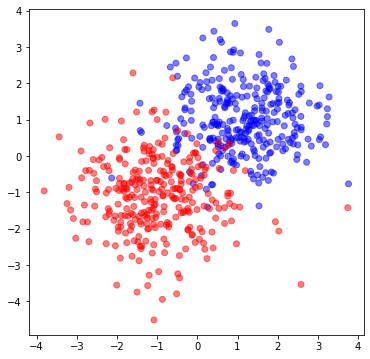

In [ ]:
np.random.seed(1201)

# data should be centered
n = 300
X1 = np.array([ 1.0 + np.random.randn(n),  1.0 + np.random.randn(n)]).T
X2 = np.array([-1.0 + np.random.randn(n), -1.0 + np.random.randn(n)]).T
X  = np.concatenate((X1,X2))
Y  = np.concatenate((np.repeat(-1, n), np.repeat(1, n)))

fig, ax = plt.subplots(figsize=(6,6))
colors = np.where(Y==1,'r','b')
ax.scatter(X[:,0], X[:,1], c=colors, alpha=0.5);

And write the model in CVX:

In [ ]:
C = 100
beta0 = Variable()
beta  = Variable(2)
slack = Variable(2*n)

objective = Minimize( (1/2) * sum_squares(vstack([beta[0], beta[1], beta0])) + C * sum(slack) )
constraints = [Y * (X @ beta + beta0) >= 1 - slack, slack >= 0]
problem = Problem(objective, constraints)
problem.solve()

-2.159099831198598e-06

Let's plot the separating line given the $\beta$ from the optimal solution:

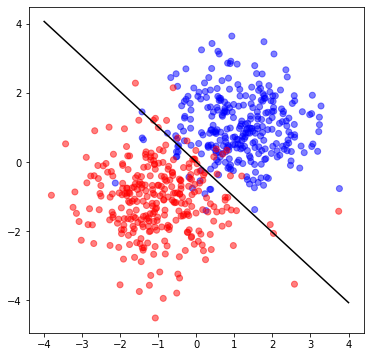

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
colors = np.where(Y==1,'r','b')
ax.scatter(X[:,0], X[:,1], c=colors, alpha=0.5);

xs = np.linspace(-4,4,50)
ys = (-beta.value[0]/beta.value[1])*xs + beta0.value/beta.value[1]
ax.plot(xs, ys, color='k');



---



## References

* [Convex Optimization MOOC](https://www.edx.org/course/convex-optimization), [examples](http://cvxr.com/cvx/examples/)

* Stephen Boyd, Lieven Vandenberghe - Convex Optimization (2004) [book available online](https://web.stanford.edu/~boyd/cvxbook/)

* [Deterministic Optimization MOOC](https://www.my-mooc.com/en/mooc/deterministic-optimization/)

Also see:

* [Minizinc](https://www.minizinc.org/), a constraint modeling language to model constraint satisfaction and optimization problems ([MOOC1](https://www.coursera.org/learn/basic-modeling), [MOOC2](https://www.coursera.org/learn/advanced-modeling))


